In [59]:
import json
import pandas as pd
import re
from googletrans import Translator
from google_trans_new import google_translator  
import time
from time import sleep
from random import uniform
import datetime
from datetime import date, timezone
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
import spacy
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import numpy as np

In [60]:
# Creating stop words list
stop_words = stopwords.words("english")

# Adding domain words 
stop_words.extend(["will","yes","#",".","_","%","|","r","sr","bamboo","media","omitted","also","media"])

# Temporal Breakdown of WhatsApp Chats

## 1. Prepare Data

In [61]:
WA_text = pd.read_csv('2021July13_whatsapptext_all_english.csv')

WA_text = WA_text[WA_text['datetime']>'2021-05-06']
WA_text = WA_text[WA_text['datetime']<'2021-06-25']

In [62]:
WA_text.shape

(13524, 13)

In [63]:
WA_text.columns

Index(['Unnamed: 0', 'datetime', 'source_type', 'source_loc', 'sender_id',
       'group_id', 'content', 'order', 'has_media', 'media_upload_loc',
       'media_mime_type', 'is_english', 'english_content'],
      dtype='object')

In [64]:
WA_text['group_id'].unique().shape

(20,)

## 2. Preliminary Analysis

In [65]:
WA_text.columns

Index(['Unnamed: 0', 'datetime', 'source_type', 'source_loc', 'sender_id',
       'group_id', 'content', 'order', 'has_media', 'media_upload_loc',
       'media_mime_type', 'is_english', 'english_content'],
      dtype='object')

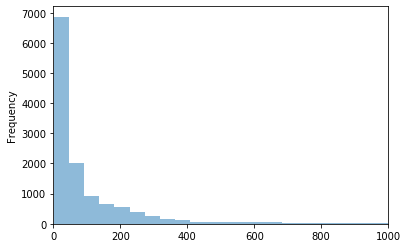

In [66]:
WA_text['content_length'] = WA_text['english_content'].str.len()
ax = WA_text['content_length'].plot.hist(bins=100, alpha=0.5,xlim=[0,1000])

In [68]:
WA_test = WA_text[WA_text['content_length']!=1]

In [69]:
WA_test.shape

(13475, 14)

In [70]:
print(WA_text['content_length'].median())

41.0


## Group Level Analysis

In [71]:
#WA_test['Date Time']=  pd.to_datetime(WA_test['Date Time'], format='%Y-%m-%d')
WA_group_id = WA_test.groupby('group_id')

In [72]:
group_id_list = WA_text['group_id'].unique()

In [74]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nlp = spacy.load('en_core_web_sm')
allowed_posttags=["NOUN", "PROPN", "VERB", "ADJ", "ADV"]


In [135]:
for group in group_id_list:
    group_text = WA_group_id.get_group(group)
    lemmatized_tokens = []
    for text in group_text["english_content"]:
        if text != text: #exclude string from tokenization if NAN
            continue
        doc = nlp(text)
        for token in doc:
            if(token.pos_ in allowed_posttags):
                lemmatized_tokens.append(token.lemma_)
    lemmatized_tokens_lower = map(str.lower, lemmatized_tokens)
    lemmatized_tokens_stopped = [token for token in lemmatized_tokens_lower if token not in stop_words]
    fdist = FreqDist(lemmatized_tokens_stopped)
    top_ten = fdist.most_common(10)
    #print(group,top_ten)


## Break Data into Time Windows

In [76]:
WA_test.columns

Index(['Unnamed: 0', 'datetime', 'source_type', 'source_loc', 'sender_id',
       'group_id', 'content', 'order', 'has_media', 'media_upload_loc',
       'media_mime_type', 'is_english', 'english_content', 'content_length'],
      dtype='object')

In [77]:
type(group_id_list)

numpy.ndarray

In [78]:
group_id_first_batch = WA_text[WA_text['datetime']<'2021-06-09']['group_id'].unique().tolist()
group_id_second_batch = list(set(group_id_list.tolist()) - set(group_id_first_batch))

In [80]:
WA_test['datetime']=  pd.to_datetime(WA_test['datetime'], format='%Y-%m-%d')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


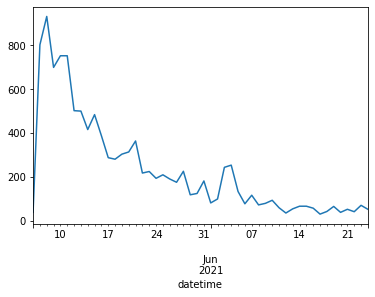

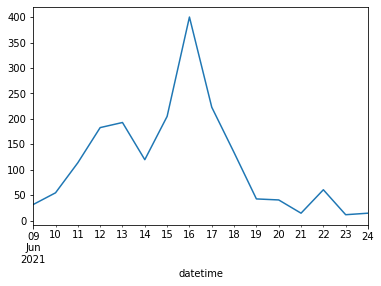

In [81]:
groups_first_batch = WA_test[WA_test['group_id'].isin(group_id_first_batch)]
groups_second_batch = WA_test[WA_test['group_id'].isin(group_id_second_batch)]

hist_time = groups_first_batch.groupby(pd.Grouper(key='datetime',freq='1D')).count()['sender_id']
hist_time.plot()
plt.show()

hist_time = groups_second_batch.groupby(pd.Grouper(key='datetime',freq='1D')).count()['sender_id']
hist_time.plot()
plt.show()


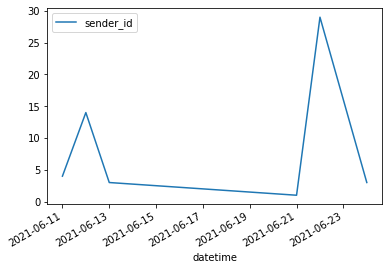

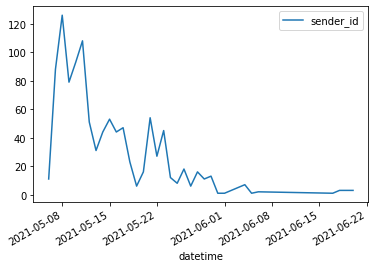

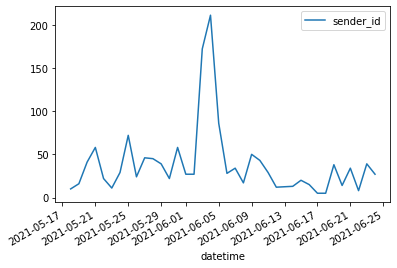

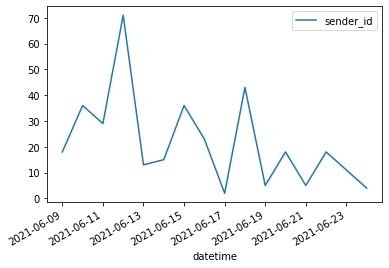

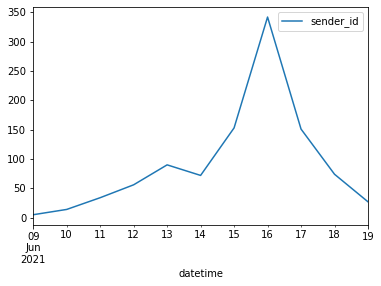

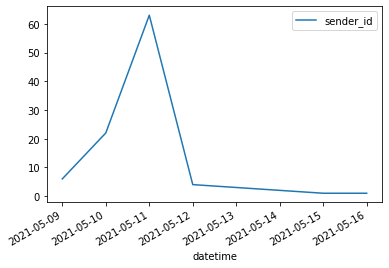

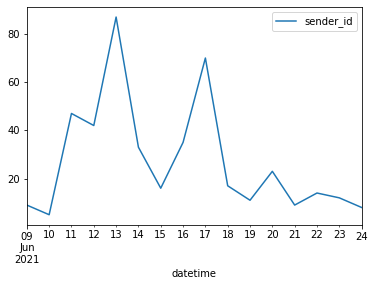

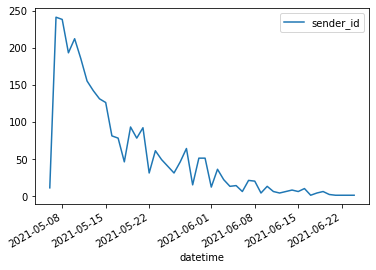

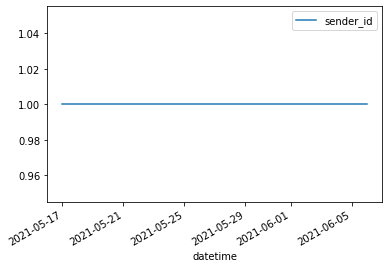

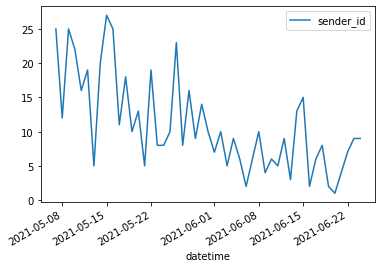

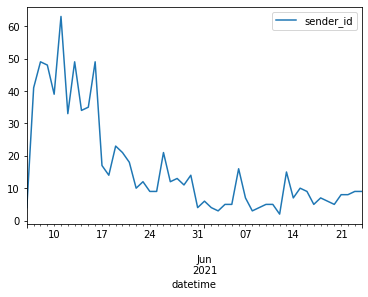

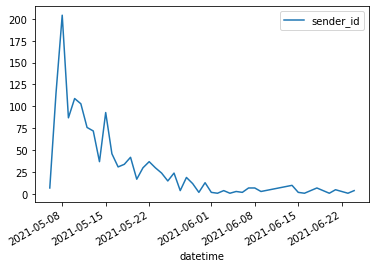

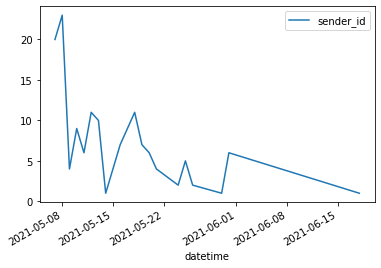

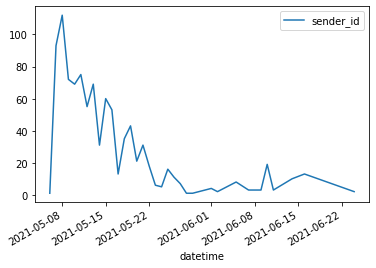

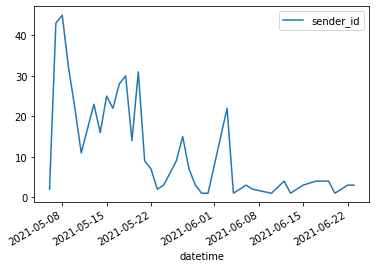

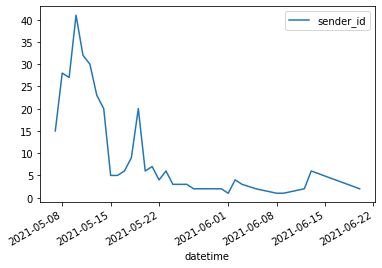

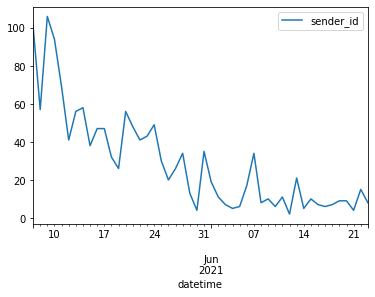

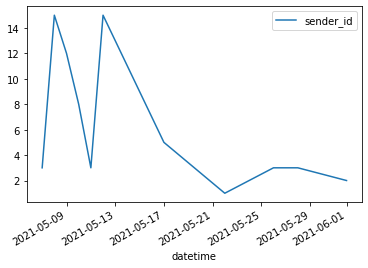

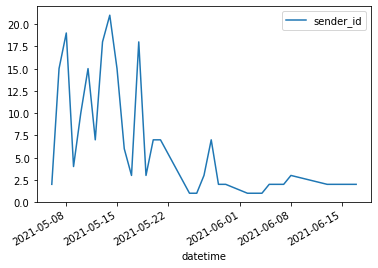

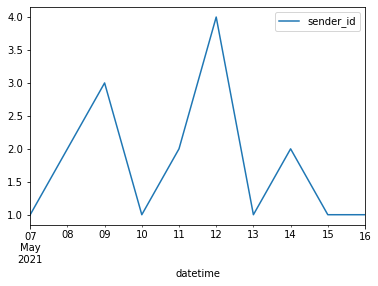

In [134]:
hist_time_group = WA_test.groupby(['group_id', pd.Grouper(key='datetime',freq='1D')]).count()['sender_id']
temp = hist_time_group.to_frame().reset_index()
temp
for group in group_id_list:
    #print(group)
    group_time = temp[temp['group_id']==group]
    group_time.plot.line(x='datetime',y='sender_id')

In [83]:
type(hist_time_group)

pandas.core.series.Series

In [90]:
groups_first_batch = WA_test[WA_test['group_id'].isin(group_id_first_batch)]

In [100]:
#groups_first_batch=groups_first_batch[groups_first_batch['group_id']=='65e0e84ecca02ddf214ad4a3df460c035c9a824a92f44354cc29bfa491e5f0ea']

groups_byweek = groups_first_batch.reset_index().groupby(pd.Grouper(key='datetime',freq='7D'))

In [93]:
for name,group in groups_byweek:
    print(name)

2021-05-06 00:00:00
2021-05-13 00:00:00
2021-05-20 00:00:00
2021-05-27 00:00:00
2021-06-03 00:00:00
2021-06-10 00:00:00
2021-06-17 00:00:00
2021-06-24 00:00:00


### Plot graph of most common words over time

In [96]:
#list of most commonly used words (calculated in separate notebook)
#freqwords = ['hospital','oxygen','patient','contact','blood','need','help','group','available','name','covid','verify']

# wordfreq_week = pd.DataFrame(columns=['Week','Word','Frequency'])
# for name,group in groups_byweek:
#     print(name)
#     groups_week = groups_byweek.get_group(name)
#     lemmatized_tokens = []
#     for text in groups_week["english_content"]:
#         if text != text: #exclude string from tokenization if NAN
#             continue
#         doc = nlp(text)
#         for token in doc:
#             if(token.pos_ in allowed_posttags):
#                 lemmatized_tokens.append(token.lemma_)
#     lemmatized_tokens_lower = map(str.lower, lemmatized_tokens)
#     lemmatized_tokens_stopped = [token for token in lemmatized_tokens_lower if token not in stop_words]
#     fdist = FreqDist(lemmatized_tokens_stopped)
# #     top_ten = fdist.most_common(10)
# #     print(name,top_ten)
# #     for word in top_ten:
# #         print(word)
# #         df_row = pd.DataFrame({'Week':[name],'Word':[word[0]],'Frequency':[word[1]]})
# #         print(df_row)
# #         wordfreq_week = wordfreq_week.append(df_row,ignore_index = True)

#     #for word in freqwords:
#     df_row = pd.DataFrame({'Week':[name],'Word':[word],'Frequency':[fdist.get(word)]})
#     print(df_row)
#     wordfreq_week = wordfreq_week.append(df_row,ignore_index = True)


In [97]:
# ## Plot word Frequencies over Time
# import plotly.express as px
# fig = px.line(wordfreq_week, x="Week", y="Frequency", color='Word')
# fig.show()

In [47]:
wordfreq_week.shape

(84, 3)

In [52]:
wordfeq_week_sum = wordfreq_week.groupby(['Week','Word']).sum()

In [131]:
WA_by_group = WA_test.groupby('group_id')
week_combined_text = pd.DataFrame(columns=['Week','Text'])
for name,group in WA_by_group:
    print(name)

In [132]:
## TF-IDF on different weeks
week_combined_text = pd.DataFrame(columns=['Week','Text'])
for name,group in groups_byweek:
    print(name)
    groups_week = groups_byweek.get_group(name)
    combined_text = groups_week["english_content"].str.cat(sep=' ')
    #print(combined_text)
    week_combined_text = week_combined_text.append(pd.DataFrame({'Week':[name],'Text':combined_text}), ignore_index = True)

In [133]:
## TF-IDF on different groups
id_combined_text = pd.DataFrame(columns=['id','Text'])
WA_by_group = WA_text.groupby(['group_id'])
for name,group in WA_by_group:
    print(name)
    groups_id = WA_by_group.get_group(name)
    combined_text = groups_id["english_content"].str.cat(sep=' ')
    print(combined_text)
    id_combined_text = id_combined_text.append(pd.DataFrame({'Week':[name],'Text':combined_text}), ignore_index = True)

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=True, stop_words=stop_words,use_idf=True)
response = tfidf.fit_transform(id_combined_text['Text'])

In [115]:
response_array = response.toarray()
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(response_array).flatten()[::-1]
n = 3
top_n = feature_array[tfidf_sorting][:n]



In [116]:
response_array.shape

(20, 24850)

In [117]:
# make the output folder if it doesn't already exist
from pathlib import Path



#output_filenames = ['week1.csv','week2.csv','week3.csv','week4.csv','week5.csv','week6.csv','week7.csv','week8.csv']
output_filenames = ['id1.csv','id2.csv','id3.csv','id4.csv','id5.csv','id6.csv','id7.csv','id8.csv','id9.csv',
                    'id10.csv','id11.csv','id12.csv','id13.csv','id14.csv','id15.csv','id16.csv','id17.csv',
                    'id18.csv','id19.csv','id20.csv','id21.csv']

for counter, doc in enumerate(response_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(tfidf.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
     
    # output to a csv using the enumerated value for the filename
    one_doc_as_df.to_csv(output_filenames[counter])

In [57]:
top_n

array(['https', 'blood', 'com'], dtype='<U91')

In [118]:
output_filenames = ['week1.csv','week2.csv','week3.csv','week4.csv','week5.csv','week6.csv','week7.csv','week8.csv']
all_week = pd.DataFrame()
for file in output_filenames:
    week_words = pd.read_csv(file)
    all_week[file] = week_words['term']


In [119]:
all_week.to_csv('all_week.csv')